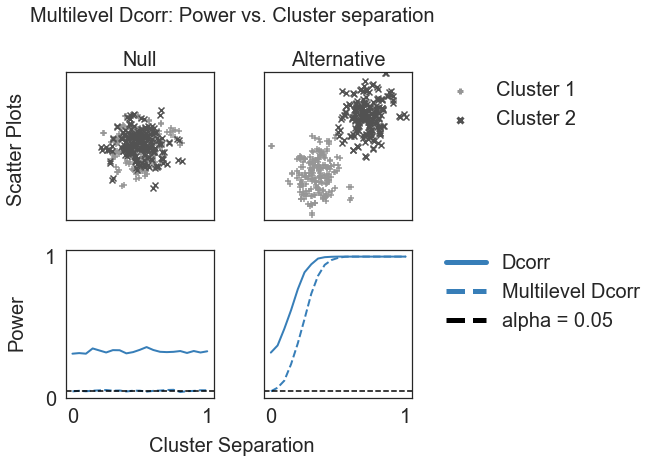

In [1]:
#%%
import sys, os

from joblib import Parallel, delayed
import numpy as np
from hyppo.independence import Dcorr
from power_2samp_multilevel import power_2samp_multilevel
from hyppo.sims.indep_sim import multilevel_gaussian

import matplotlib.pyplot as plt
from matplotlib.legend import Legend
import seaborn as sns

sys.path.append(os.path.realpath('..'))

# custom seaborn plot options to make the figures pretty
sns.set(color_codes=True, style='white', context='notebook', font_scale=1.25)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:])

import warnings
warnings.filterwarnings('ignore')

#%%
# Simulation parameters
n = 100
d = 2
group_std = 0.1

# Permutation tree blocks
Y_within = np.asarray([0, 1] * 2 * n)

blocks_across = np.c_[
    np.hstack([[i+1]*2 for i in range(2*n)]),
    -1*Y_within - 1
]

# Test params
NAME = '2samp-multilevel_vs_epsilon'
MAX_EPSILON = 1.0# 0.6
STEP_SIZE = 0.05
EPSILONS = np.arange(0, MAX_EPSILON + STEP_SIZE, STEP_SIZE)
WEIGHTS = EPSILONS
POWER_REPS = 5
REPS = 1000
n_jobs = 5

tests = [
    Dcorr
]

multilevels = [False, True]

cases = [
    0,
    1,
]

run = False#True#
plot = True#False#

#%%
def estimate_power(case, test, multilevel=False):
    if multilevel:
        blocks = blocks_across
    else:
        blocks = None

    est_power = np.array([
        np.mean([power_2samp_multilevel(test, n=n, epsilon=epsilon*case, workers=n_jobs, d=d, reps=REPS, blocks=blocks)
        for _ in range(POWER_REPS)]) for epsilon in EPSILONS])

    if not os.path.exists(f'../ksample/{NAME}/'):
        os.makedirs(f'../ksample/{NAME}/')
    if multilevel:
        np.savetxt('../ksample/{}/{}_{}_multilevel.csv'.format(NAME, case, test.__name__),
                est_power, delimiter=',')
    else:
        np.savetxt('../ksample/{}/{}_{}.csv'.format(NAME, case, test.__name__),
                est_power, delimiter=',')
    return est_power


# In[ ]:

if run:
    outputs = Parallel(n_jobs=n_jobs, verbose=100)(
        [delayed(estimate_power)(case, test, multilevel) for case in cases for test in tests for multilevel in multilevels]
    )

#%%

FONTSIZE = 20

def plot_power():
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
    
    sim_title = [
        "Null",
        "Alternative",
    ]
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            case = cases[j]
            if i == 0:
                X, Y = multilevel_gaussian(n=100, epsilon=4*case)
                sims = (X, Y)
                
                sim_markers = [
                    "+",
                    "x"
                ]
                custom_color = [
                    "#969696",
                    "#525252"
                ]
                
                count = 0
                scatters = []
                for count, sim in enumerate(sims):
                    x, y = np.hsplit(sim, 2)
                    scatters.append(col.scatter(x, y, marker=sim_markers[count], color=custom_color[count]))

                col.set_xticks([])
                col.set_yticks([])
                col.set_title(sim_title[j], fontsize=FONTSIZE)
                if case == 0:
                    col.set_xlim(-5, 5)
                    col.set_ylim(-5, 5)
                else:
                    col.set_ylim(-3, 7)
                    col.set_ylim(-3, 7)
                
            else:
                for test in tests:
                    custom_color = {
                        "Dcorr" : "#377eb8",
                        "Hsic" : "#4daf4a",
                        "MGC" : "#e41a1c",
                    }

                    for multilevel in multilevels:
                        if multilevel:
                            power = np.genfromtxt('../ksample/{}/{}_{}_multilevel.csv'.format(NAME, case, test.__name__),
                                          delimiter=',')

                            ls = '--'
                            label = f'Multilevel {test.__name__}'
                        else:
                            power = np.genfromtxt('../ksample/{}/{}_{}.csv'.format(NAME, case, test.__name__),
                                          delimiter=',')

                            ls = '-'
                            label = test.__name__
                        if test.__name__ in custom_color.keys():
                            col.plot(EPSILONS, power, custom_color[test.__name__], label=label, lw=2, ls=ls)
                        else:
                            col.plot(EPSILONS, power, label=label, lw=2, ls=ls)
                    col.tick_params(labelsize=FONTSIZE)
                    col.set_xticks([EPSILONS[0], EPSILONS[-1]])
                    col.set_ylim(0, 1.05)
                    col.set_yticks([])
                    if j == 0:
                        col.set_yticks([0, 1])
                col.axhline(0.05, ls='--', c='black', label='alpha = 0.05')
            col.set_aspect(np.diff(col.get_xlim())/np.diff(col.get_ylim()))
    
    fig.text(0.5, 0, 'Cluster Separation', ha='center', fontsize=FONTSIZE)
#     fig.text(0.75, 0, 'Increasing Weight', ha='center')
    fig.text(0.11, 0.3, 'Power', va='center', rotation='vertical', fontsize=FONTSIZE)
    fig.text(0.11, 0.7, 'Scatter Plots', va='center', rotation='vertical', fontsize=FONTSIZE)
    
    leg = plt.legend(bbox_to_anchor=(1.04, 0.5), bbox_transform=plt.gcf().transFigure,
                     ncol=1, loc='upper center', fontsize=FONTSIZE)
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.20)
    plt.subplots_adjust(wspace=-.20)
    leg = Legend(fig, scatters, ['Cluster 1', 'Cluster 2'], loc='upper center', frameon=False, ncol=1,
                bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(0.98, 0.9), fontsize=FONTSIZE)
    fig.add_artist(leg);
    for legobj in leg.legendHandles:
        legobj.set_linewidth(3.0)
    plt.suptitle('Multilevel Dcorr: Power vs. Cluster separation', fontsize=FONTSIZE, y=1.03)
    # plt.savefig(f'../ksample/figs/{NAME}.pdf', transparent=True, bbox_inches='tight')

if plot:
    plot_power()